In [6]:
import os
import json
import pandas as pd
import pydash

'''
@function getValueFromJson
@description Returns value from the json for the key passed
@default returns zero if key is not found
'''
def getValueFromJson(json, key, default=0): 
    return pydash.get(json, key, default)

path = 'C'
filelist = os.listdir(path)


In [17]:
extract = []
for file in filelist:
    with open(f'C/{file}','r') as f:
        data = json.load(f)
    
        team1 = getValueFromJson(data,'info.teams.0')
        team2 = getValueFromJson(data,'info.teams.1')
        outcome = getValueFromJson(data,'info.outcome.winner')
        startDate = getValueFromJson(data,'info.dates.0')
        endDate = getValueFromJson(data,'info.dates')[-1]
        season = getValueFromJson(data,'info.season')

        if outcome == 0:
            outcome = getValueFromJson(data,'info.outcome.result')
        extract.append({
            'startDate' : startDate,
            'endDate' : endDate,
            'team1' : team1,
            'team2' : team2,
            'outcome' : outcome,
            'season' : str(season)
        })

In [18]:
df = pd.DataFrame(extract)

In [19]:
df.startDate = pd.to_datetime(df.startDate)
df.endDate = pd.to_datetime(df.endDate)

In [25]:
df.sort_values('startDate',inplace=True)
df.reset_index(drop=True,inplace=True)

In [27]:
df.to_csv('test_match_results.csv',index=False)

In [45]:
df = df[df['outcome']=='draw']
# df[(df['team1'] == 'India') or (df['team2']=='India')]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

,team,eloRating,totalMatches,wins,ties,winRatio
0,Chennai Super Kings,1135.425,224,131,1,0.585
1,Royal Challengers Bangalore,1112.128,240,114,3,0.475
2,Gujarat Titans,1087.169,33,23,0,0.697
3,Mumbai Indians,1059.750,247,138,4,0.559
4,Kings XI Punjab,1040.295,190,85,4,0.447
5,Punjab Kings,1036.382,42,19,0,0.452
6,Lucknow Super Giants,1009.630,30,17,0,0.567
7,Delhi Daredevils,989.220,161,67,1,0.416
8,Delhi Capitals,989.095,77,38,3,0.494
9,Gujarat Lions,988.398,30,13,1,0.433


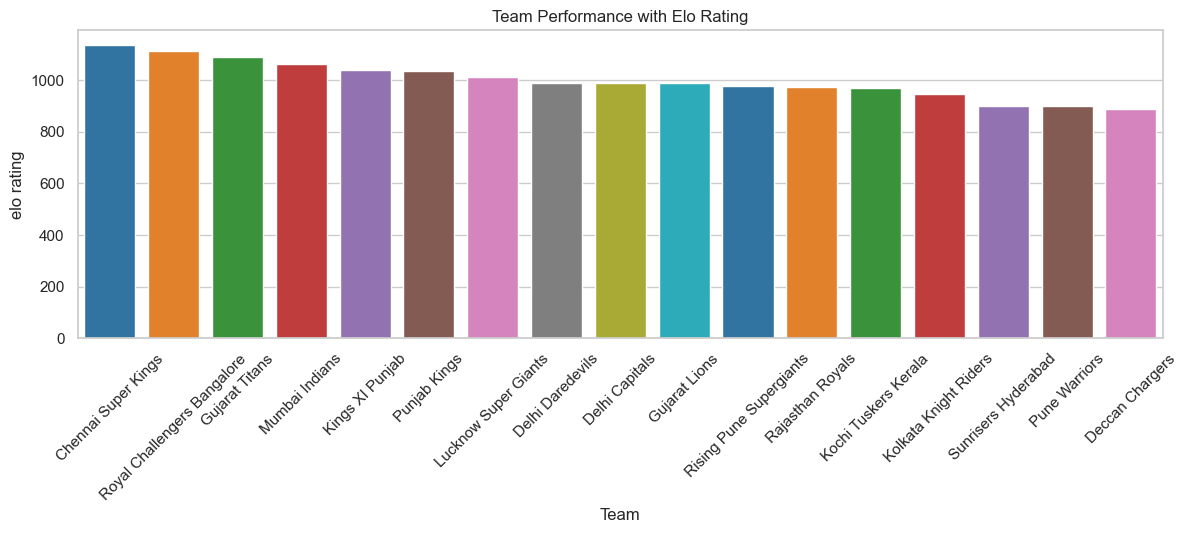

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from ipynb.fs.full.ipl import updateElo,expectedScore

In [56]:
df = pd.read_csv('test_match_results.csv')

In [57]:
df.sample(5)

,startDate,endDate,team1,team2,outcome,season
256,2010-12-16,2010-12-20,South Africa,India,South Africa,2010/11
110,2007-06-15,2007-06-19,West Indies,England,England,2007
623,2019-02-09,2019-02-12,West Indies,England,England,2018/19
209,2009-12-02,2009-12-06,India,Sri Lanka,India,2009/10
422,2014-11-26,2014-11-30,New Zealand,Pakistan,New Zealand,2014/15


In [58]:
currentElo = {team: 1000 for team in set(df['team1']).union(set(df['team2']))}
eloRatingMatch = []
matchCount = {team: 0 for team in set(df['team1']).union(set(df['team2']))}
winCount = {team: 0 for team in set(df['team1']).union(set(df['team2']))}
tieCount = {team: 0 for team in set(df['team1']).union(set(df['team2']))}

for index, row in df.iterrows():
    startDate = row['startDate']
    endDate = row['endDate']
    team1 = row['team1']
    team2 = row['team2']
    winner = row['outcome']
    season = row['season']
    outcome = 'win' if row['outcome'] == team1 else 'tie' if row['outcome'] == 'draw' else 'no_result'


    matchCount[team1] += 1
    matchCount[team2] += 1

    # Update win counts
    if winner == team1:
        winCount[team1] += 1
    elif winner == team2:
        winCount[team2] += 1
    elif winner == 'tie':
        tieCount[team1] +=1
        tieCount[team2] += 1
    # Update Elo ratings
    kFactor = 30

    newEloTeam1, newEloTeam2 = updateElo(currentElo[team1], currentElo[team2], outcome,kFactor)

    eloRatingMatch.append((matchCount[team1], team1, newEloTeam1,season))
    eloRatingMatch.append((matchCount[team2], team2, newEloTeam2,season))

    # Set new Elo ratings in the DataFrame
    df.at[index, 'eloTeam1'] = newEloTeam1
    df.at[index, 'eloTeam2'] = newEloTeam2

    # Update current Elo ratings
    currentElo[team1] = newEloTeam1
    currentElo[team2] = newEloTeam2

In [59]:
eloData = list(currentElo.items())
eloDf = pd.DataFrame(eloData, columns=['team', 'eloRating'])
eloDf.sort_values('eloRating',ascending=False,inplace=True)
eloDf.reset_index(inplace=True,drop=True)
eloDf['totalMatches'] = eloDf['team'].map(matchCount)
eloDf['wins'] = eloDf['team'].map(winCount)
eloDf['draw'] = eloDf['team'].map(drawCount)
eloDf['winRatio'] = round(eloDf['wins'] / eloDf['totalMatches'],3) 
display(eloDf)

,team,eloRating,totalMatches,wins,draw,winRatio
0,Australia,1181.235,216,115,42.0,0.532
1,India,1178.820,198,96,53.0,0.485
2,South Africa,1112.561,175,87,31.0,0.497
3,England,1072.116,255,107,61.0,0.420
4,New Zealand,1039.407,148,57,32.0,0.385
5,Afghanistan,986.648,7,3,NaN,0.429
6,Sri Lanka,982.800,161,61,36.0,0.379
7,ICC World XI,982.084,1,0,NaN,0.000
8,Ireland,955.992,7,0,NaN,0.000
9,Pakistan,927.104,145,52,31.0,0.359


In [40]:
df1 = pd.DataFrame(eloRatingMatch,columns=['startDate','endDate','matchNo','team','eloRating','season'])

In [41]:
df1

,startDate,endDate,matchNo,team,eloRating,season
0,2002-12-26,2002-12-29,1,South Africa,1015.000,2002/03
1,2002-12-29,2002-12-29,1,Pakistan,985.000,2002/03
2,2002-12-26,2002-12-30,1,Australia,1015.000,2002/03
3,2002-12-30,2002-12-30,1,England,985.000,2002/03
4,2003-01-02,2003-01-06,2,England,1006.723,2002/03
...,...,...,...,...,...,...
1607,2023-12-24,2023-12-24,197,India,1178.820,2023/24
1608,2023-12-26,2023-12-28,198,India,1178.820,2023/24
1609,2023-12-28,2023-12-28,175,South Africa,1112.561,2023/24
1610,2023-12-26,2023-12-29,216,Australia,1181.235,2023/24
